# Epsilon Clustering
Cluster splats that are within an epsilon distance of each other.

In [1]:
from IPython.terminal.shortcuts import filter_from_string

# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Epsilon distance.
EPSILON = 0.11

In [2]:
from clustering_exploration.utils.data_handler import load_splats
splats = load_splats(DATA_NAME)


# Cluster Splats
For each pixel, take a splat and
1. If there are no clusters, create a new dictionary entry with the splat's depth as the key and the alpha and color as the value.
2. If there are clusters, find the closest cluster by EPSILON distance and add it to that splats dictionary entry.
3. If 2 fails, create a new dictionary entry. 

In [3]:
from clustering_exploration.algorithms.epsilon import EpsilonAlgorithm
clustered_splats = EpsilonAlgorithm(splats, EPSILON).compute()

Shuffling splats...
Clustering splats...


  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

  0%|          | 0/1051648 [00:00<?, ?it/s]

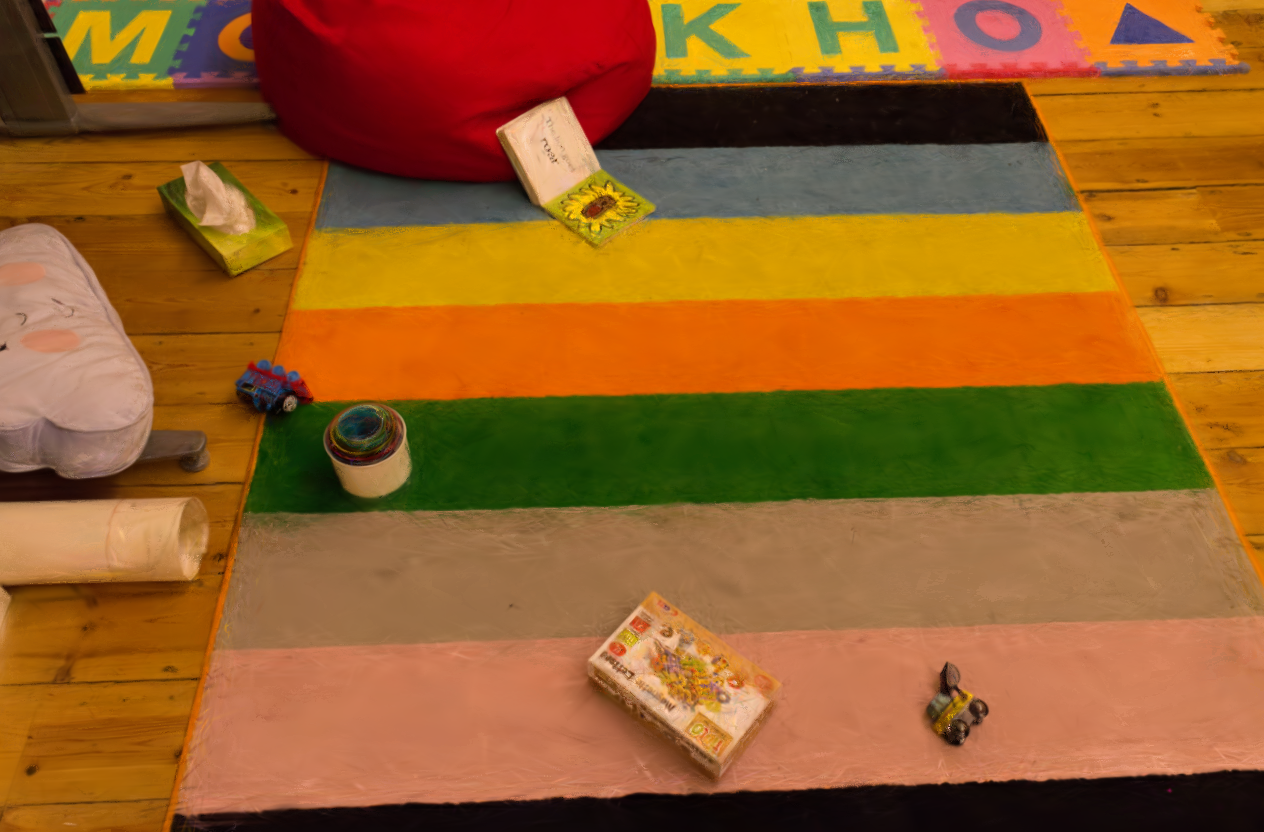

In [4]:
from clustering_exploration.utils.image_handler import compute_image_from_clusters
display(compute_image_from_clusters(clustered_splats, "epsilon_clustering_1"))